In [1]:
import pandas as pd

In [50]:
df = pd.read_csv('/SGRNJ06/randd/PROJECT/RD20073101_ScRNA_VDJ/2022_cm/20230628_M_PBMC_15/jiace1/M_PBMC_15x_RT1Nlib/04.analysis/M_PBMC_15x_RT1Nlib_tsne_coord.tsv',sep='\t', index_col=0)

In [61]:
df['sample'] = 'mouse_PBMC_BCR_TCR'

In [54]:
barcode_cluster_dict = df['cluster'].to_dict()


In [57]:
t_threshold = 0
b_threshold = 0
#df_tcr = pd.read_csv('/SGRNJ06/randd/USER/zhouyiqi/work/upload/scircle/sCircle_mouse_PBMC_TCR_BCR/TCR/mouse_PBMC_TCR/05.match/matched_productive_contig_annotations.csv')
df_tcr = pd.read_csv('/SGRNJ06/randd/USER/zhouyiqi/work/upload/scircle/sCircle_mouse_PBMC_TCR_BCR/TCR/outs/matched_productive_contig_annotations.csv')
tcr_barcodes = set(df_tcr['barcode'])

#df_bcr = pd.read_csv('/SGRNJ06/randd/USER/zhouyiqi/work/upload/scircle/sCircle_mouse_PBMC_TCR_BCR/BCR/mouse_PBMC_BCR/05.match/matched_productive_contig_annotations.csv')
df_bcr = pd.read_csv('/SGRNJ06/randd/USER/zhouyiqi/work/upload/scircle/sCircle_mouse_PBMC_TCR_BCR/BCR/outs/matched_productive_contig_annotations.csv')
bcr_barcodes = set(df_bcr[df_bcr['umis'] >= b_threshold]['barcode'])

In [48]:
len(tcr_barcodes)

1836

In [58]:
from collections import defaultdict
# 创建 cluster -> list of barcodes 的反向索引
cluster_barcodes = defaultdict(list)
for barcode, cluster in barcode_cluster_dict.items():
    cluster_barcodes[cluster].append(barcode)

# 准备统计结果
cluster_stats = []

for cluster, barcodes in cluster_barcodes.items():
    total = len(barcodes)
    tcr_count = sum(bc in tcr_barcodes for bc in barcodes)
    bcr_count = sum(bc in bcr_barcodes for bc in barcodes)

    cluster_stats.append({
        'cluster': cluster,
        'total_cells': total,
        'TCR+ cells': f"{tcr_count} ({tcr_count/total:.2%})",
        'BCR+ cells': f"{bcr_count} ({bcr_count/total:.2%})"
    })

# 转为 DataFrame 查看
cluster_stats_df = pd.DataFrame(cluster_stats).sort_values(by='cluster')
print(cluster_stats_df)

    cluster  total_cells     TCR+ cells     BCR+ cells
2         1         1554    142 (9.14%)  1388 (89.32%)
9         2         1375  1187 (86.33%)   150 (10.91%)
7         3          960   842 (87.71%)   139 (14.48%)
1         4          797    81 (10.16%)    84 (10.54%)
8         5          713   628 (88.08%)    91 (12.76%)
3         6          642     63 (9.81%)   583 (90.81%)
12        7          419     34 (8.11%)   392 (93.56%)
6         8          394    72 (18.27%)    95 (24.11%)
14        9          381    66 (17.32%)    72 (18.90%)
11       10          308   236 (76.62%)    48 (15.58%)
13       11          267     25 (9.36%)     18 (6.74%)
15       12          216    26 (12.04%)   202 (93.52%)
16       13          214     19 (8.88%)     16 (7.48%)
10       14          191   170 (89.01%)    30 (15.71%)
0        15          124   102 (82.26%)   110 (88.71%)
19       16           75      5 (6.67%)      2 (2.67%)
18       17           50     5 (10.00%)    45 (90.00%)
17       1

In [39]:
tcr_barcodes = set(tcr_barcodes)
bcr_barcodes = set(bcr_barcodes)

In [59]:
t_cell_clusters = {2, 3, 5, 10, 14, 21}
b_cell_clusters = {1, 6, 7, 12, 17, 23}
# 获取各类细胞 barcode
t_cells = set(df[df['cluster'].isin(t_cell_clusters)].index)
b_cells = set(df[df['cluster'].isin(b_cell_clusters)].index)

In [27]:
tcr_signal = df_tcr[df_tcr['barcode'].isin(t_cells)]['umis'].median()
tcr_signal

11.0

In [29]:
tcr_noise = df_tcr[df_tcr['barcode'].isin(b_cells)]['umis'].median()
tcr_noise

10.0

In [30]:
print("TCR UMI Median Statistics:")
print(f"  Signal (T cells): {tcr_signal}")
print(f"  Noise (B cells): {tcr_noise}")

# BCR 信号（B细胞中的 BCR umis）
bcr_signal = df_bcr[df_bcr['barcode'].isin(b_cells)]['umis'].median()

# BCR 背景噪声（T细胞中的 BCR umis）
bcr_noise = df_bcr[df_bcr['barcode'].isin(t_cells)]['umis'].median()

# 输出结果
print("BCR UMI Median Statistics:")
print(f"  Signal (B cells): {bcr_signal}")
print(f"  Noise (T cells): {bcr_noise}")

TCR UMI Median Statistics:
  Signal (T cells): 11.0
  Noise (B cells): 10.0
BCR UMI Median Statistics:
  Signal (B cells): 10.0
  Noise (T cells): 11.0


In [41]:
t_cell_clusters = {2, 3, 5, 10, 14}
b_cell_clusters = {1, 6, 7, 12}
doublet_clusters = {15}

# 获取各类细胞 barcode
t_cells = set(df[df['cluster'].isin(t_cell_clusters)].index)
b_cells = set(df[df['cluster'].isin(b_cell_clusters)].index)

# 表达情况交集
t_cells_tcr = t_cells & tcr_barcodes
t_cells_bcr = t_cells & bcr_barcodes
t_cells_both = t_cells_tcr & t_cells_bcr

b_cells_bcr = b_cells & bcr_barcodes
b_cells_tcr = b_cells & tcr_barcodes
b_cells_both = b_cells_bcr & b_cells_tcr

# Output statistics

print("T cell:")
print(f"  Total: {len(t_cells)}")
print(f"  With assembled TCR: {len(t_cells_tcr)} ({len(t_cells_tcr)/len(t_cells)*100:.2f}%)")
print(f"  With assembled BCR: {len(t_cells_bcr)} ({len(t_cells_bcr)/len(t_cells)*100:.2f}%)")
print(f"  With both assembled TCR and BCR: {len(t_cells_both)} ({len(t_cells_both)/len(t_cells)*100:.2f}%)\n")

print("B cell:")
print(f"  Total: {len(b_cells)}")
print(f"  With assembled BCR: {len(b_cells_bcr)} ({len(b_cells_bcr)/len(b_cells)*100:.2f}%)")
print(f"  With assembled TCR: {len(b_cells_tcr)} ({len(b_cells_tcr)/len(b_cells)*100:.2f}%)")
print(f"  With both assembled BCR and TCR: {len(b_cells_both)} ({len(b_cells_both)/len(b_cells)*100:.2f}%)")


T cell:
  Total: 2587
  With assembled TCR: 1239 (47.89%)
  With assembled BCR: 219 (8.47%)
  With both assembled TCR and BCR: 112 (4.33%)

B cell:
  Total: 2831
  With assembled BCR: 2016 (71.21%)
  With assembled TCR: 65 (2.30%)
  With both assembled BCR and TCR: 41 (1.45%)


In [60]:
import pandas as pd

# 假设df是包含以下列的DataFrame: barcode, sample, cluster
# tcr_barcodes 是set，包含有TCR的barcode
# doublet_clusters, t_cell_clusters 是set

def compute_summary(df, tcr_barcodes, t_cell_clusters, doublet_clusters):
    summary = []

    for sample, group in df.groupby('sample'):
        total_cells = len(group)

        # Doublets
        doublets = group[group['cluster'].isin(doublet_clusters)]
        doublet_count = len(doublets)
        doublet_pct = f"{doublet_count} ({doublet_count / total_cells:.2%})"

        # T cells
        t_cells = group[group['cluster'].isin(t_cell_clusters)]
        t_cell_count = len(t_cells)

        # T cells with TCR
        t_cells_with_tcr = t_cells[t_cells['barcode'].isin(tcr_barcodes)]
        t_cell_with_tcr_count = len(t_cells_with_tcr)
        t_cell_with_tcr_pct = f"{t_cell_with_tcr_count} ({t_cell_with_tcr_count / t_cell_count:.2%})" if t_cell_count > 0 else "0 (0.00%)"

        # Non-T cells with TCR
        non_t_cells = group[~group['cluster'].isin(t_cell_clusters | doublet_clusters)]
        non_t_cells_with_tcr = non_t_cells[non_t_cells['barcode'].isin(tcr_barcodes)]
        non_t_cell_with_tcr_count = len(non_t_cells_with_tcr)
        non_t_cell_with_tcr_pct = f"{non_t_cell_with_tcr_count} ({non_t_cell_with_tcr_count / len(non_t_cells):.2%})" if len(non_t_cells) > 0 else "0 (0.00%)"

        summary.append({
            "Sample": sample,
            "Total Cells": total_cells,
            "Doublets": doublet_pct,
            "Total T Cells": t_cell_count,
            "T cell with TCR": t_cell_with_tcr_pct,
            "Non-T cell with TCR": non_t_cell_with_tcr_pct
        })

    return pd.DataFrame(summary)


In [67]:
df.index.name = 'barcode'
df = df.reset_index()
df

,barcode,tSNE_1,tSNE_2,cluster,Gene_Counts,sample
0,AAACATCGAACCGAGAATGCCTAA,9.271687,-5.536144,15,2250,mouse_PBMC_BCR_TCR
1,AAACATCGAACCGAGATATCAGCA,7.102550,86.283000,4,1385,mouse_PBMC_BCR_TCR
2,AAACATCGAACGTGATATTGGCTC,11.393305,-40.023243,1,1207,mouse_PBMC_BCR_TCR
3,AAACATCGAAGACGGACAGCGTTA,-12.981411,-57.666380,6,1627,mouse_PBMC_BCR_TCR
4,AAACATCGAAGGTACAGATAGACA,29.863672,-29.356016,1,847,mouse_PBMC_BCR_TCR
...,...,...,...,...,...,...
8903,TTCACGCATCTTCACAAGCCATGC,12.682347,-46.640102,1,1267,mouse_PBMC_BCR_TCR
8904,TTCACGCATGGAACAAAGGCTAAC,-25.195522,-9.077155,2,1344,mouse_PBMC_BCR_TCR
8905,TTCACGCATGGAACAACTGAGCCA,-58.599655,56.914936,13,434,mouse_PBMC_BCR_TCR
8906,TTCACGCATGGAACAATGGCTTCA,63.538452,10.559968,8,1918,mouse_PBMC_BCR_TCR


In [68]:
t_cell_clusters = {2, 3, 5, 10, 14}
b_cell_clusters = {1, 6, 7, 12}
doublet_clusters = {15}
compute_summary(df, tcr_barcodes, t_cell_clusters, doublet_clusters)

,Sample,Total Cells,Doublets,Total T Cells,T cell with TCR,Non-T cell with TCR
0,mouse_PBMC_BCR_TCR,8908,124 (1.39%),3547,3063 (86.35%),586 (11.19%)


In [69]:
compute_summary(df, bcr_barcodes, b_cell_clusters, doublet_clusters)

,Sample,Total Cells,Doublets,Total T Cells,T cell with TCR,Non-T cell with TCR
0,mouse_PBMC_BCR_TCR,8908,124 (1.39%),2831,2565 (90.60%),847 (14.23%)


In [2]:
# 10X
df_tsne = pd.read_csv('/SGRNJ06/randd/USER/zhouyiqi/work/analysis/20250721-vdj-crosstalk/10x/BALB_mice/analysis/tsne/2_components/projection.csv')
df_tsne

,Barcode,TSNE-1,TSNE-2
0,AAACCTGAGCAACGGT-1,-21.186489,18.739919
1,AAACCTGAGCAGCCTC-1,28.652080,25.646264
2,AAACCTGAGTTAACGA-1,26.473812,-13.380610
3,AAACCTGCATCCGGGT-1,14.311641,-36.119066
4,AAACCTGCATCTACGA-1,-0.870095,24.465934
...,...,...,...
7995,TTTGTCAGTGTTTGGT-1,26.253477,-20.866402
7996,TTTGTCATCCGAGCCA-1,-31.960329,4.277426
7997,TTTGTCATCGCTTGTC-1,-21.638693,-0.513774
7998,TTTGTCATCGTAGGTT-1,28.589719,-20.625329


In [3]:
tcr_barcodes = pd.read_csv('/SGRNJ06/randd/USER/zhouyiqi/work/analysis/20250721-vdj-crosstalk/10x/BALB_mice/analysis/tsne/2_components/vdj_v1_mm_balbc_pbmc_t_filtered_contig_annotations.csv').barcode
tcr_barcodes

0       AAACCTGAGTTAACGA-1
1       AAACCTGAGTTAACGA-1
2       AAACCTGAGTTAACGA-1
3       AAACCTGAGTTAACGA-1
4       AAACCTGCATCCGGGT-1
               ...        
6807    TTTGTCAAGCGATAGC-1
6808    TTTGTCAGTGTTTGGT-1
6809    TTTGTCAGTGTTTGGT-1
6810    TTTGTCATCGTAGGTT-1
6811    TTTGTCATCGTAGGTT-1
Name: barcode, Length: 6812, dtype: object

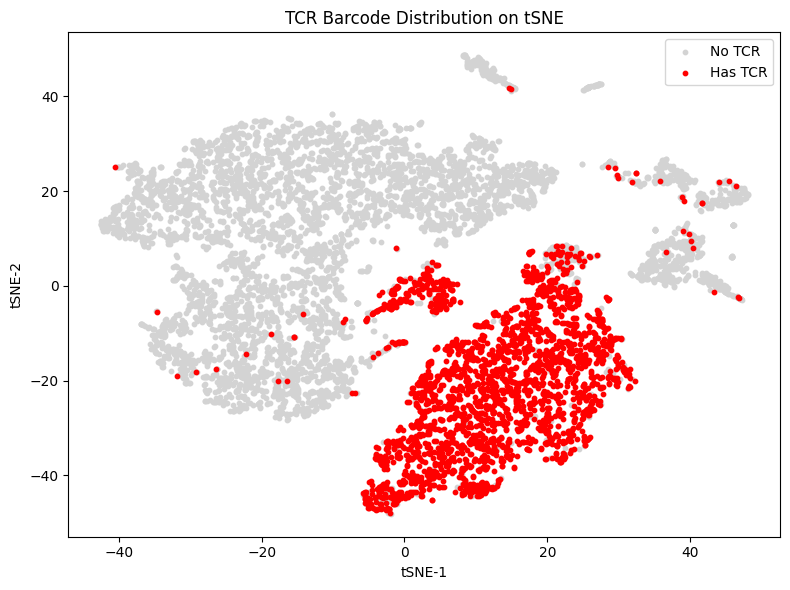

In [6]:
import matplotlib.pyplot as plt
# 标记是否有TCR
df_tsne['has_tcr'] = df_tsne['Barcode'].isin(tcr_barcodes)

# 绘图
plt.figure(figsize=(8, 6))
# 没有 TCR 的灰色
plt.scatter(df_tsne.loc[~df_tsne['has_tcr'], 'TSNE-1'],
            df_tsne.loc[~df_tsne['has_tcr'], 'TSNE-2'],
            c='lightgray', s=10, label='No TCR')

# 有 TCR 的红色
plt.scatter(df_tsne.loc[df_tsne['has_tcr'], 'TSNE-1'],
            df_tsne.loc[df_tsne['has_tcr'], 'TSNE-2'],
            c='red', s=10, label='Has TCR')

plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.title('TCR Barcode Distribution on tSNE')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
df_cluster = pd.read_csv('/SGRNJ06/randd/USER/zhouyiqi/work/analysis/20250721-vdj-crosstalk/10x/BALB_mice/analysis/clustering/graphclust/clusters.csv')
df_cluster

,Barcode,Cluster
0,AAACCTGAGCAACGGT-1,1
1,AAACCTGAGCAGCCTC-1,11
2,AAACCTGAGTTAACGA-1,1
3,AAACCTGCATCCGGGT-1,4
4,AAACCTGCATCTACGA-1,7
...,...,...
7995,TTTGTCAGTGTTTGGT-1,3
7996,TTTGTCATCCGAGCCA-1,1
7997,TTTGTCATCGCTTGTC-1,5
7998,TTTGTCATCGTAGGTT-1,3


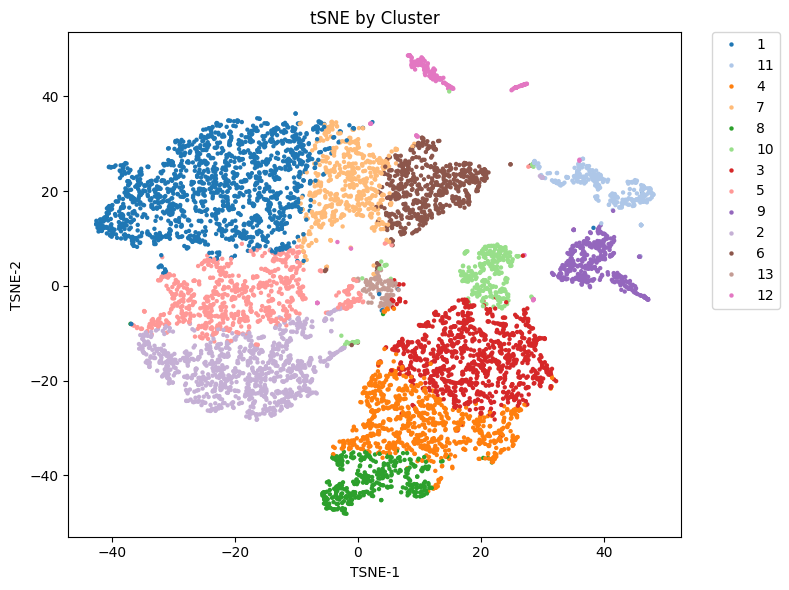

In [10]:
import seaborn as sns
df = pd.merge(df_tsne, df_cluster, on='Barcode')

# 转换为字符串型以便 seaborn 分类调色板生效
df['Cluster'] = df['Cluster'].astype(str)

# 画图
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='TSNE-1', y='TSNE-2', hue='Cluster', palette='tab20', s=10, linewidth=0)

plt.title('tSNE by Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

In [11]:
# 添加has_TCR标志
df['has_TCR'] = df['Barcode'].isin(tcr_barcodes)

# 分组统计
summary = df.groupby('Cluster')['has_TCR'].value_counts().unstack().fillna(0)
summary.columns = ['no_TCR', 'has_TCR']  # False = no_TCR, True = has_TCR

# 添加总数和百分比
summary['total'] = summary['has_TCR'] + summary['no_TCR']
summary['%_has_TCR'] = (summary['has_TCR'] / summary['total'] * 100).round(2)
summary['%_no_TCR'] = (summary['no_TCR'] / summary['total'] * 100).round(2)

# 重置索引方便查看
summary = summary.reset_index()

# 展示结果
print(summary)

   Cluster  no_TCR  has_TCR  total  %_has_TCR  %_no_TCR
0        1    1617        7   1624       0.43     99.57
1       10     120      193    313      61.66     38.34
2       11     298       13    311       4.18     95.82
3       12     184        8    192       4.17     95.83
4       13      12       99    111      89.19     10.81
5        2     979       33   1012       3.26     96.74
6        3      36      944    980      96.33      3.67
7        4      39      756    795      95.09      4.91
8        5     718       57    775       7.35     92.65
9        6     580        2    582       0.34     99.66
10       7     522        2    524       0.38     99.62
11       8      45      358    403      88.83     11.17
12       9     370        8    378       2.12     97.88


In [17]:
summary.sort_values('total', ascending=False)

,Cluster,no_TCR,has_TCR,total,%_has_TCR,%_no_TCR
0,1,1617,7,1624,0.43,99.57
5,2,979,33,1012,3.26,96.74
6,3,36,944,980,96.33,3.67
7,4,39,756,795,95.09,4.91
8,5,718,57,775,7.35,92.65
9,6,580,2,582,0.34,99.66
10,7,522,2,524,0.38,99.62
11,8,45,358,403,88.83,11.17
12,9,370,8,378,2.12,97.88
1,10,120,193,313,61.66,38.34


In [18]:
# 步骤1: 选出 has_TCR 占比小于 10% 的 cluster
background_clusters = summary[summary['%_has_TCR'] < 10]

# 步骤2: 统计这些 cluster 中的细胞总数
background_cell_count = background_clusters['has_TCR'].sum()

# 步骤3: 总细胞数
total_cells = summary['total'].sum()

# 步骤4: 计算背景污染百分比
background_percent = round(background_cell_count / total_cells * 100, 2)

# 打印结果
print(f"背景污染细胞数：{background_cell_count}")
print(f"总细胞数：{total_cells}")
print(f"背景污染细胞占比：{background_percent}%")

背景污染细胞数：130
总细胞数：8000
背景污染细胞占比：1.62%


In [42]:
df = pd.read_csv('/SGRNJ06/randd/USER/zhouyiqi/work/analysis/20250721-vdj-crosstalk/10x/BALB_mice/analysis/clustering/graphclust/clusters.csv')
tcr_barcodes = pd.read_csv('/SGRNJ06/randd/USER/zhouyiqi/work/analysis/20250721-vdj-crosstalk/10x/BALB_mice/vdj_v1_mm_balbc_pbmc_b_filtered_contig_annotations.csv').barcode

# 添加has_TCR标志
df['has_TCR'] = df['Barcode'].isin(tcr_barcodes)

# 分组统计
summary = df.groupby('Cluster')['has_TCR'].value_counts().unstack().fillna(0)
summary.columns = ['no_TCR', 'has_TCR']  # False = no_TCR, True = has_TCR

# 添加总数和百分比
summary['total'] = summary['has_TCR'] + summary['no_TCR']
summary['%_has_TCR'] = (summary['has_TCR'] / summary['total'] * 100).round(2)
summary['%_no_TCR'] = (summary['no_TCR'] / summary['total'] * 100).round(2)

# 重置索引方便查看
summary = summary.reset_index()

# 展示结果
print(summary)
# 步骤1: 选出 has_TCR 占比小于 10% 的 cluster
background_clusters = summary[summary['%_has_TCR'] < 10]

# 步骤2: 统计这些 cluster 中的细胞总数
background_cell_count = background_clusters['has_TCR'].sum()

# 步骤3: 总细胞数
total_cells = summary['total'].sum()

# 步骤4: 计算背景污染百分比
background_percent = round(background_cell_count / total_cells * 100, 2)

# 打印结果
print(f"背景污染细胞数：{background_cell_count}")
print(f"总细胞数：{total_cells}")
print(f"背景污染细胞占比：{background_percent}%")

    Cluster  no_TCR  has_TCR   total  %_has_TCR  %_no_TCR
0         1    22.0   1602.0  1624.0      98.65      1.35
1         2     0.0   1012.0  1012.0     100.00      0.00
2         3   966.0     14.0   980.0       1.43     98.57
3         4   788.0      7.0   795.0       0.88     99.12
4         5     1.0    774.0   775.0      99.87      0.13
5         6     8.0    574.0   582.0      98.63      1.37
6         7     6.0    518.0   524.0      98.85      1.15
7         8   401.0      2.0   403.0       0.50     99.50
8         9   347.0     31.0   378.0       8.20     91.80
9        10   290.0     23.0   313.0       7.35     92.65
10       11   264.0     47.0   311.0      15.11     84.89
11       12   174.0     18.0   192.0       9.38     90.62
12       13     2.0    109.0   111.0      98.20      1.80
背景污染细胞数：95.0
总细胞数：8000.0
背景污染细胞占比：1.19%
